# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 6 steps, each in a single notebook:
1. Get probe template
2. **Get the Bragg disks**
3. Determine the diffraction shifts
4. Calculate lattice vectors
5. Calculate strain
6. Visualize strain maps

# Notebook 2: Get the Bragg disks

In this step the Bragg disks are located, as follows:

* For each diffraction pattern:
    * Cross correlate (or hybrid cross-phase correlate) the DP with the probe kernel
    * Get a first guess at Bragg disk positions by identifying positions and intensities of all local maxima
    * Filter out erroneous peaks by removing those too close together, in order of decreasing intensity
* Save Bragg disks list

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from time import time

from py4DSTEM.process.datastructure import PointList

In [2]:
# # Load the raw data
# fp = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.dm3"
# dc = py4DSTEM.readwrite.read_data(fp)
# dc.set_scan_shape(60,60)
# dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

In [3]:
# Load data
fp = "/home/ben/Data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5"
dc = py4DSTEM.readwrite.read_data_v0_1(fp)
dc.data4D = np.roll(dc.data4D,-2,1) # Correct for acquisition wrap-around error

Reading file /home/ben/Data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5...

/home/ben/Data/20180905_FePO4_unlithiated/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4.h5 is a py4DSTEM HDF5 file.  Reading...


In [4]:
# # Load the template
# fp_probetemplate = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/vacuum_probe_kernel.h5"
# browser = py4DSTEM.readwrite.FileBrowser(fp_probetemplate)
# browser.show_dataobjects()
# probe_kernel = browser.get_dataobject(0)

In [5]:
# Load the template
fp_probetemplate = "/home/ben/Data/20180905_FePO4_unlithiated/processing/vacuum_probe_kernel.h5"
browser = py4DSTEM.readwrite.FileBrowser(fp_probetemplate, rawdatacube=dc)
browser.show_dataobjects()
probe_kernel = browser.get_dataobject(0)

 Index                  Name                        Type        
   0    probe_kernel                        DiffractionSlice    


### Loop through DPs, finding all Bragg disks

In [5]:
corrPower = 0.9
sigma_gaussianFilter = 2
edge_boundary = 20
maxNumPeaks = 45
minPeakSpacing = 32

coords = [('rx',float),('ry',float),('qx',float),('qy',float),('intensity',float)]
Bragg_peak_point_list = PointList(coordinates=coords, parentDataCube=dc, name="Bragg_disks")

t0=time()
probe_kernel_FT = np.conj(np.fft.fft2(probe_kernel.data2D))
for Ri in range(dc.R_Nx):
    for Rj in range(dc.R_Ny):
        print("Analyzing scan position {},{}".format(Ri,Rj))

        # Get diffraction pattern
        DP = dc.data4D[Ri,Rj,:,:]
        
        # Cross correlation     
        cc = py4DSTEM.process.utils.get_cross_correlation_fk(DP,probe_kernel_FT,corrPower)

        # Gaussian smoothing
        cc = np.maximum(cc,0)
        cc = gaussian_filter(cc, sigma_gaussianFilter)
        
        # Get maximal points
        max_points = py4DSTEM.process.utils.get_maximal_points(cc)
        
        # Remove points at edges
        max_points[:edge_boundary,:]=False
        max_points[-edge_boundary:,:]=False
        max_points[:,:edge_boundary]=False
        max_points[:,-edge_boundary:]=False    
       
        # Make point_list with structured array datatype ('rx','ry','qx','qy','intensity')
        point_list = PointList(coordinates=coords, parentDataCube=dc, save_behavior=False)

        max_point_indices_x, max_point_indices_y = np.nonzero(max_points)
        point_intensities = cc[max_point_indices_x,max_point_indices_y]

        length = len(point_intensities)
        for i in range(length):
            new_point = (Ri,Rj,max_point_indices_x[i],max_point_indices_y[i],point_intensities[i])
            point_list.add_point(new_point)
        
        # Order point list, keep only up to maxNumPeaks
        numPeaks = min(maxNumPeaks,length)
        point_list.sort(coordinate='intensity',order='descending')
        point_list.data = point_list.data[:numPeaks]        
        
        # Remove peaks that are too close together
        r2 = minPeakSpacing**2
        deletePeaks = np.zeros(numPeaks,dtype=bool)
        for i in range(numPeaks):
            if deletePeaks[i] == False:
                tooClose = ( (point_list.data['qx']-point_list.data['qx'][i])**2 + \
                          (point_list.data['qy']-point_list.data['qy'][i])**2 ) < r2
                tooClose[:i+1] = False
                deletePeaks[tooClose] = True
        point_list.remove_points(deletePeaks)
    
        # Add current point list to running list
        Bragg_peak_point_list.add_pointlist(point_list)
            
t=time()-t0
print("Finished in {}h {}m {}s".format(int(t/3600),int(t/60),int(t%60)))

Analyzing scan position 0,0
Analyzing scan position 0,1
Analyzing scan position 0,2
Analyzing scan position 0,3
Analyzing scan position 0,4
Analyzing scan position 0,5
Analyzing scan position 0,6
Analyzing scan position 0,7
Analyzing scan position 0,8
Analyzing scan position 0,9
Analyzing scan position 0,10
Analyzing scan position 0,11
Analyzing scan position 0,12
Analyzing scan position 0,13
Analyzing scan position 0,14
Analyzing scan position 0,15
Analyzing scan position 0,16
Analyzing scan position 0,17
Analyzing scan position 0,18
Analyzing scan position 0,19
Analyzing scan position 0,20
Analyzing scan position 0,21
Analyzing scan position 0,22
Analyzing scan position 0,23
Analyzing scan position 0,24
Analyzing scan position 0,25
Analyzing scan position 0,26
Analyzing scan position 0,27
Analyzing scan position 0,28
Analyzing scan position 0,29
Analyzing scan position 0,30
Analyzing scan position 0,31
Analyzing scan position 0,32
Analyzing scan position 0,33
Analyzing scan position 

Analyzing scan position 4,48
Analyzing scan position 4,49
Analyzing scan position 4,50
Analyzing scan position 4,51
Analyzing scan position 4,52
Analyzing scan position 4,53
Analyzing scan position 4,54
Analyzing scan position 4,55
Analyzing scan position 4,56
Analyzing scan position 4,57
Analyzing scan position 4,58
Analyzing scan position 4,59
Analyzing scan position 5,0
Analyzing scan position 5,1
Analyzing scan position 5,2
Analyzing scan position 5,3
Analyzing scan position 5,4
Analyzing scan position 5,5
Analyzing scan position 5,6
Analyzing scan position 5,7
Analyzing scan position 5,8
Analyzing scan position 5,9
Analyzing scan position 5,10
Analyzing scan position 5,11
Analyzing scan position 5,12
Analyzing scan position 5,13
Analyzing scan position 5,14
Analyzing scan position 5,15
Analyzing scan position 5,16
Analyzing scan position 5,17
Analyzing scan position 5,18
Analyzing scan position 5,19
Analyzing scan position 5,20
Analyzing scan position 5,21
Analyzing scan position 

Analyzing scan position 9,36
Analyzing scan position 9,37
Analyzing scan position 9,38
Analyzing scan position 9,39
Analyzing scan position 9,40
Analyzing scan position 9,41
Analyzing scan position 9,42
Analyzing scan position 9,43
Analyzing scan position 9,44
Analyzing scan position 9,45
Analyzing scan position 9,46
Analyzing scan position 9,47
Analyzing scan position 9,48
Analyzing scan position 9,49
Analyzing scan position 9,50
Analyzing scan position 9,51
Analyzing scan position 9,52
Analyzing scan position 9,53
Analyzing scan position 9,54
Analyzing scan position 9,55
Analyzing scan position 9,56
Analyzing scan position 9,57
Analyzing scan position 9,58
Analyzing scan position 9,59
Analyzing scan position 10,0
Analyzing scan position 10,1
Analyzing scan position 10,2
Analyzing scan position 10,3
Analyzing scan position 10,4
Analyzing scan position 10,5
Analyzing scan position 10,6
Analyzing scan position 10,7
Analyzing scan position 10,8
Analyzing scan position 10,9
Analyzing scan

Analyzing scan position 14,12
Analyzing scan position 14,13
Analyzing scan position 14,14
Analyzing scan position 14,15
Analyzing scan position 14,16
Analyzing scan position 14,17
Analyzing scan position 14,18
Analyzing scan position 14,19
Analyzing scan position 14,20
Analyzing scan position 14,21
Analyzing scan position 14,22
Analyzing scan position 14,23
Analyzing scan position 14,24
Analyzing scan position 14,25
Analyzing scan position 14,26
Analyzing scan position 14,27
Analyzing scan position 14,28
Analyzing scan position 14,29
Analyzing scan position 14,30
Analyzing scan position 14,31
Analyzing scan position 14,32
Analyzing scan position 14,33
Analyzing scan position 14,34
Analyzing scan position 14,35
Analyzing scan position 14,36
Analyzing scan position 14,37
Analyzing scan position 14,38
Analyzing scan position 14,39
Analyzing scan position 14,40
Analyzing scan position 14,41
Analyzing scan position 14,42
Analyzing scan position 14,43
Analyzing scan position 14,44
Analyzing 

Analyzing scan position 18,48
Analyzing scan position 18,49
Analyzing scan position 18,50
Analyzing scan position 18,51
Analyzing scan position 18,52
Analyzing scan position 18,53
Analyzing scan position 18,54
Analyzing scan position 18,55
Analyzing scan position 18,56
Analyzing scan position 18,57
Analyzing scan position 18,58
Analyzing scan position 18,59
Analyzing scan position 19,0
Analyzing scan position 19,1
Analyzing scan position 19,2
Analyzing scan position 19,3
Analyzing scan position 19,4
Analyzing scan position 19,5
Analyzing scan position 19,6
Analyzing scan position 19,7
Analyzing scan position 19,8
Analyzing scan position 19,9
Analyzing scan position 19,10
Analyzing scan position 19,11
Analyzing scan position 19,12
Analyzing scan position 19,13
Analyzing scan position 19,14
Analyzing scan position 19,15
Analyzing scan position 19,16
Analyzing scan position 19,17
Analyzing scan position 19,18
Analyzing scan position 19,19
Analyzing scan position 19,20
Analyzing scan posit

Analyzing scan position 23,24
Analyzing scan position 23,25
Analyzing scan position 23,26
Analyzing scan position 23,27
Analyzing scan position 23,28
Analyzing scan position 23,29
Analyzing scan position 23,30
Analyzing scan position 23,31
Analyzing scan position 23,32
Analyzing scan position 23,33
Analyzing scan position 23,34
Analyzing scan position 23,35
Analyzing scan position 23,36
Analyzing scan position 23,37
Analyzing scan position 23,38
Analyzing scan position 23,39
Analyzing scan position 23,40
Analyzing scan position 23,41
Analyzing scan position 23,42
Analyzing scan position 23,43
Analyzing scan position 23,44
Analyzing scan position 23,45
Analyzing scan position 23,46
Analyzing scan position 23,47
Analyzing scan position 23,48
Analyzing scan position 23,49
Analyzing scan position 23,50
Analyzing scan position 23,51
Analyzing scan position 23,52
Analyzing scan position 23,53
Analyzing scan position 23,54
Analyzing scan position 23,55
Analyzing scan position 23,56
Analyzing 

Analyzing scan position 27,59
Analyzing scan position 28,0
Analyzing scan position 28,1
Analyzing scan position 28,2
Analyzing scan position 28,3
Analyzing scan position 28,4
Analyzing scan position 28,5
Analyzing scan position 28,6
Analyzing scan position 28,7
Analyzing scan position 28,8
Analyzing scan position 28,9
Analyzing scan position 28,10
Analyzing scan position 28,11
Analyzing scan position 28,12
Analyzing scan position 28,13
Analyzing scan position 28,14
Analyzing scan position 28,15
Analyzing scan position 28,16
Analyzing scan position 28,17
Analyzing scan position 28,18
Analyzing scan position 28,19
Analyzing scan position 28,20
Analyzing scan position 28,21
Analyzing scan position 28,22
Analyzing scan position 28,23
Analyzing scan position 28,24
Analyzing scan position 28,25
Analyzing scan position 28,26
Analyzing scan position 28,27
Analyzing scan position 28,28
Analyzing scan position 28,29
Analyzing scan position 28,30
Analyzing scan position 28,31
Analyzing scan posit

Analyzing scan position 32,35
Analyzing scan position 32,36
Analyzing scan position 32,37
Analyzing scan position 32,38
Analyzing scan position 32,39
Analyzing scan position 32,40
Analyzing scan position 32,41
Analyzing scan position 32,42
Analyzing scan position 32,43
Analyzing scan position 32,44
Analyzing scan position 32,45
Analyzing scan position 32,46
Analyzing scan position 32,47
Analyzing scan position 32,48
Analyzing scan position 32,49
Analyzing scan position 32,50
Analyzing scan position 32,51
Analyzing scan position 32,52
Analyzing scan position 32,53
Analyzing scan position 32,54
Analyzing scan position 32,55
Analyzing scan position 32,56
Analyzing scan position 32,57
Analyzing scan position 32,58
Analyzing scan position 32,59
Analyzing scan position 33,0
Analyzing scan position 33,1
Analyzing scan position 33,2
Analyzing scan position 33,3
Analyzing scan position 33,4
Analyzing scan position 33,5
Analyzing scan position 33,6
Analyzing scan position 33,7
Analyzing scan pos

Analyzing scan position 37,11
Analyzing scan position 37,12
Analyzing scan position 37,13
Analyzing scan position 37,14
Analyzing scan position 37,15
Analyzing scan position 37,16
Analyzing scan position 37,17
Analyzing scan position 37,18
Analyzing scan position 37,19
Analyzing scan position 37,20
Analyzing scan position 37,21
Analyzing scan position 37,22
Analyzing scan position 37,23
Analyzing scan position 37,24
Analyzing scan position 37,25
Analyzing scan position 37,26
Analyzing scan position 37,27
Analyzing scan position 37,28
Analyzing scan position 37,29
Analyzing scan position 37,30
Analyzing scan position 37,31
Analyzing scan position 37,32
Analyzing scan position 37,33
Analyzing scan position 37,34
Analyzing scan position 37,35
Analyzing scan position 37,36
Analyzing scan position 37,37
Analyzing scan position 37,38
Analyzing scan position 37,39
Analyzing scan position 37,40
Analyzing scan position 37,41
Analyzing scan position 37,42
Analyzing scan position 37,43
Analyzing 

Analyzing scan position 41,47
Analyzing scan position 41,48
Analyzing scan position 41,49
Analyzing scan position 41,50
Analyzing scan position 41,51
Analyzing scan position 41,52
Analyzing scan position 41,53
Analyzing scan position 41,54
Analyzing scan position 41,55
Analyzing scan position 41,56
Analyzing scan position 41,57
Analyzing scan position 41,58
Analyzing scan position 41,59
Analyzing scan position 42,0
Analyzing scan position 42,1
Analyzing scan position 42,2
Analyzing scan position 42,3
Analyzing scan position 42,4
Analyzing scan position 42,5
Analyzing scan position 42,6
Analyzing scan position 42,7
Analyzing scan position 42,8
Analyzing scan position 42,9
Analyzing scan position 42,10
Analyzing scan position 42,11
Analyzing scan position 42,12
Analyzing scan position 42,13
Analyzing scan position 42,14
Analyzing scan position 42,15
Analyzing scan position 42,16
Analyzing scan position 42,17
Analyzing scan position 42,18
Analyzing scan position 42,19
Analyzing scan posit

Analyzing scan position 46,23
Analyzing scan position 46,24
Analyzing scan position 46,25
Analyzing scan position 46,26
Analyzing scan position 46,27
Analyzing scan position 46,28
Analyzing scan position 46,29
Analyzing scan position 46,30
Analyzing scan position 46,31
Analyzing scan position 46,32
Analyzing scan position 46,33
Analyzing scan position 46,34
Analyzing scan position 46,35
Analyzing scan position 46,36
Analyzing scan position 46,37
Analyzing scan position 46,38
Analyzing scan position 46,39
Analyzing scan position 46,40
Analyzing scan position 46,41
Analyzing scan position 46,42
Analyzing scan position 46,43
Analyzing scan position 46,44
Analyzing scan position 46,45
Analyzing scan position 46,46
Analyzing scan position 46,47
Analyzing scan position 46,48
Analyzing scan position 46,49
Analyzing scan position 46,50
Analyzing scan position 46,51
Analyzing scan position 46,52
Analyzing scan position 46,53
Analyzing scan position 46,54
Analyzing scan position 46,55
Analyzing 

Analyzing scan position 50,58
Analyzing scan position 50,59
Analyzing scan position 51,0
Analyzing scan position 51,1
Analyzing scan position 51,2
Analyzing scan position 51,3
Analyzing scan position 51,4
Analyzing scan position 51,5
Analyzing scan position 51,6
Analyzing scan position 51,7
Analyzing scan position 51,8
Analyzing scan position 51,9
Analyzing scan position 51,10
Analyzing scan position 51,11
Analyzing scan position 51,12
Analyzing scan position 51,13
Analyzing scan position 51,14
Analyzing scan position 51,15
Analyzing scan position 51,16
Analyzing scan position 51,17
Analyzing scan position 51,18
Analyzing scan position 51,19
Analyzing scan position 51,20
Analyzing scan position 51,21
Analyzing scan position 51,22
Analyzing scan position 51,23
Analyzing scan position 51,24
Analyzing scan position 51,25
Analyzing scan position 51,26
Analyzing scan position 51,27
Analyzing scan position 51,28
Analyzing scan position 51,29
Analyzing scan position 51,30
Analyzing scan posit

Analyzing scan position 55,34
Analyzing scan position 55,35
Analyzing scan position 55,36
Analyzing scan position 55,37
Analyzing scan position 55,38
Analyzing scan position 55,39
Analyzing scan position 55,40
Analyzing scan position 55,41
Analyzing scan position 55,42
Analyzing scan position 55,43
Analyzing scan position 55,44
Analyzing scan position 55,45
Analyzing scan position 55,46
Analyzing scan position 55,47
Analyzing scan position 55,48
Analyzing scan position 55,49
Analyzing scan position 55,50
Analyzing scan position 55,51
Analyzing scan position 55,52
Analyzing scan position 55,53
Analyzing scan position 55,54
Analyzing scan position 55,55
Analyzing scan position 55,56
Analyzing scan position 55,57
Analyzing scan position 55,58
Analyzing scan position 55,59
Analyzing scan position 56,0
Analyzing scan position 56,1
Analyzing scan position 56,2
Analyzing scan position 56,3
Analyzing scan position 56,4
Analyzing scan position 56,5
Analyzing scan position 56,6
Analyzing scan po

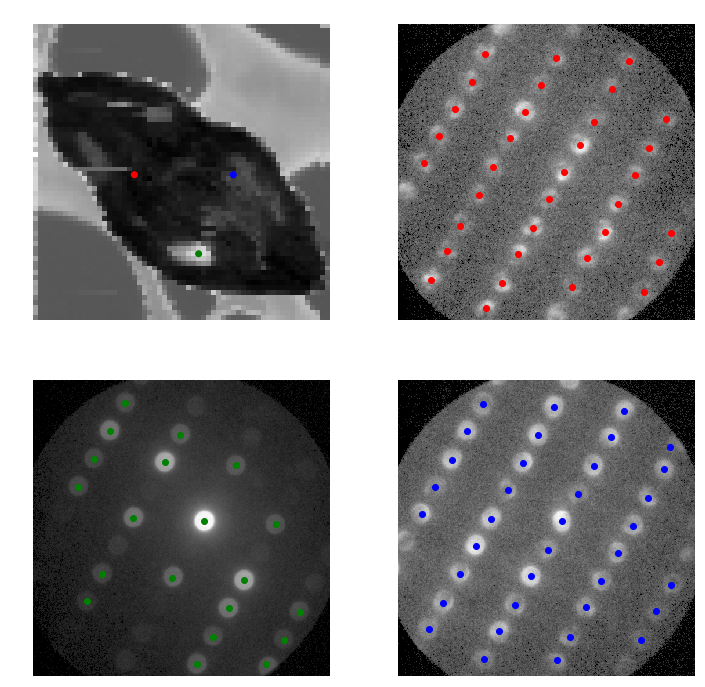

In [6]:
# Show points found for a few DPs

xs=(30,46,30)
ys=(20,33,40)
power=0.3

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data4D[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data4D[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data4D[xs[2],ys[2],:,:]**power)

peaks0 = Bragg_peak_point_list.get_subpointlist([('rx',xs[0]),('ry',ys[0])])
peaks1 = Bragg_peak_point_list.get_subpointlist([('rx',xs[1]),('ry',ys[1])])
peaks2 = Bragg_peak_point_list.get_subpointlist([('rx',xs[2]),('ry',ys[2])])

ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r')
ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g')
ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b')

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

### Save Bragg disk list

In [7]:
# # Save

# savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/Bragg_disks.h5"
# py4DSTEM.readwrite.save_dataobject(Bragg_peak_point_list,savepath)

In [8]:
# Save

savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Bragg_disks.h5"
py4DSTEM.readwrite.save_dataobject(Bragg_peak_point_list,savepath)

Creating file /home/ben/Data/20180905_FePO4_unlithiated/processing/Bragg_disks.h5...
Writing metadata...
Done.
